# Sample Bias 1D

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics.pairwise import rbf_kernel
from adapt.instance_based import KMM, KLIEP
from adapt.feature_based import CORAL, DeepCORAL, DANN, mSDA

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import clone_model
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.callbacks import Callback

import sys
sys.path.append("../wann/methods")
from WANN import WANN

## Network

In [2]:
def get_estimator(shape=2, output_shape=(1,), C=1., activation=None, name=""):
    model = Sequential()
    model.add(Dense(100, activation="relu", input_shape=(shape,),
                   kernel_constraint=MaxNorm(C),
                   bias_constraint=MaxNorm(C)))
    model.add(Dense(100, activation="relu",
                   kernel_constraint=MaxNorm(C),
                   bias_constraint=MaxNorm(C)))
    model.add(Dense(1, activation=activation,
                   kernel_constraint=MaxNorm(C),
                   bias_constraint=MaxNorm(C),
                   bias_initializer="zeros"))
    model.compile(loss="mse", optimizer=Adam(0.001))
    return model

fit_params = dict(epochs=300, batch_size=128, verbose=0)

In [3]:
class _SavePrediction(Callback):  
    """
    Callbacks which stores predicted weights
    and labels in history at each epoch.
    """
    def __init__(self, X, y):
        self.X = X
        self.y = y
        super().__init__()
            
    def on_epoch_end(self, batch, logs={}):
        """Applied at the end of each epoch"""
        if "val_loss" not in self.model.history.history:
            self.model.history.history["val_loss"] = []
        predictions = self.model.predict_on_batch([self.X, self.X,
                                          self.y, self.y, self.y])
        y_pred = predictions[0].ravel()
        val_loss = np.mean(np.square(self.y.ravel() - y_pred))
        self.model.history.history["val_loss"].append(
        val_loss
        )

## Setup

In [5]:
np.random.seed(0)
seeds = np.random.choice(2**16, 10)

scores = {}
scores_200 = {}
scores_wann = {}
hist = {"epochs": [], "N": [], "val_loss": [], "random_state": []}
hist_200 = {"epochs": [], "N": [], "val_loss": [], "random_state": []}
hist_wann = {"epochs": [], "N": [], "val_loss": [], "random_state": []}

for N in [32, 64, 128, 256]:
    scores[N] = []
    scores_200[N] = []
    scores_wann[N] = []
    
    m = 1000
    n = 1000
    perc = 0.2

    prob = [perc] + [(1-perc) / (N-1)] * (N-1)
    alphas = np.random.choice(N, m, p=prob)
    betas = np.zeros((alphas.size, N))
    betas[np.arange(alphas.size), alphas] = 1

    mus = np.random.random((N, N)) * 2 - 1

    Xs = np.random.randn(m, N) + betas.dot(mus)
    Xt = np.random.randn(m, N) + mus[0]

    def f(x):
        return np.mean(np.abs(x), 1)

    ys = f(Xs)
    yt = f(Xt)
    
    for i in range(10):

        np.random.seed(seeds[i])
        tf.random.set_seed(seeds[i])
        
        print("Base")
        
        estimator = get_estimator(N)
        estimator.fit(Xs, ys, **fit_params, validation_data=(Xt, yt));
        
        hist["epochs"] += list(np.arange(1, 301))
        hist["N"] += [N] * 300
        hist["random_state"] += [i] * 300
        hist["val_loss"] += estimator.history.history["val_loss"]
        
        plt.plot(estimator.history.history["val_loss"])
        
        err_s = mean_absolute_error(
            estimator.predict(Xs).ravel(), ys)
        err_t = mean_absolute_error(
            estimator.predict(Xt).ravel(), yt)

        scores[N].append(err_t)

        print("source %.5f"%err_s)
        print("target %.5f"%err_t)
        
        print("Tgt 200")
        
        estimator = get_estimator(N)
        estimator.fit(Xs[alphas==0], ys[alphas==0], **fit_params, validation_data=(Xt, yt));
        
        hist_200["epochs"] += list(np.arange(1, 301))
        hist_200["N"] += [N] * 300
        hist_200["random_state"] += [i] * 300
        hist_200["val_loss"] += estimator.history.history["val_loss"]
        
        plt.plot(estimator.history.history["val_loss"])
        
        err_s = mean_absolute_error(
            estimator.predict(Xs).ravel(), ys)
        err_t = mean_absolute_error(
            estimator.predict(Xt).ravel(), yt)

        scores_200[N].append(err_t)

        print("source %.5f"%err_s)
        print("target %.5f"%err_t)
        
        print("WANN")
        
        wann = WANN(get_estimator, C=1., optimizer=Adam(0.001))
        wann.fit(Xs, ys, [np.arange(len(Xs)), np.argwhere(alphas==0).ravel()], **fit_params, callbacks=[_SavePrediction(Xt, yt)]);
        
        hist_wann["epochs"] += list(np.arange(1, 301))
        hist_wann["N"] += [N] * 300
        hist_wann["random_state"] += [i] * 300
        hist_wann["val_loss"] += wann.model.history.history["val_loss"]
        
        plt.plot(wann.model.history.history["val_loss"])
        
        err_s = mean_squared_error(
            wann.predict(Xs).ravel(), ys)
        err_t = mean_squared_error(
            wann.predict(Xt).ravel(), yt)

        scores_wann[N].append(err_t)

        print("source %.5f"%err_s)
        print("target %.5f"%err_t)
        
        plt.yscale("log")
        plt.show()

In [6]:
import pandas as pd
pd.DataFrame(scores_200).to_csv("../dataset/results/synth_tgtonly_score.csv")
pd.DataFrame(hist_200).to_csv("../dataset/results/synth_tgtonly_hist.csv")

pd.DataFrame(scores).to_csv("../dataset/results/synth_base_score.csv")
pd.DataFrame(hist).to_csv("../dataset/results/synth_base_hist.csv")

pd.DataFrame(scores_wann).to_csv("../dataset/results/synth_wann_score.csv")
pd.DataFrame(hist_wann).to_csv("../dataset/results/synth_wann_hist.csv")

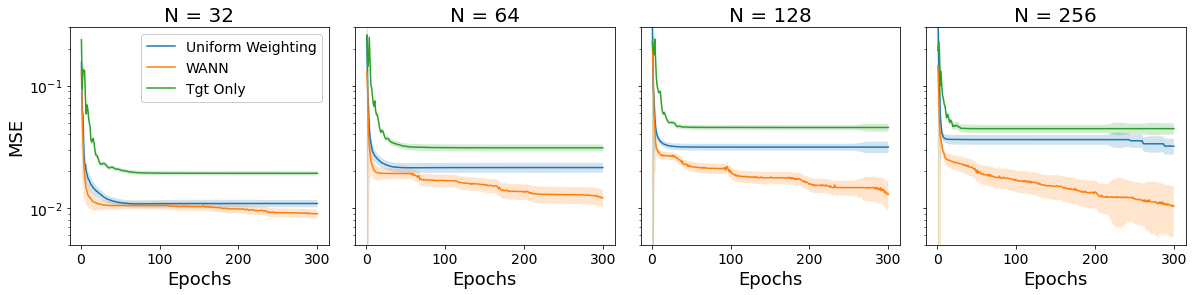

In [33]:
fig, axes = plt.subplots(1, 4, figsize=(20, 4))

for N, ax in zip([32, 64, 128, 256], axes.ravel()):
    df_ = pd.read_csv("../dataset/results/synth_base_hist.csv", index_col=0)
    val_loss = df_.loc[df_.N == N].groupby(["epochs"])["val_loss"].median()
    std_loss = df_.loc[df_.N == N].groupby(["epochs"])["val_loss"].std()
    ax.plot(np.arange(1, 301), val_loss, label="Uniform Weighting")
    ax.fill_between(np.arange(1, 301), val_loss-std_loss, val_loss+std_loss, alpha=0.2)
    
    df_ = pd.read_csv("../dataset/results/synth_wann_hist.csv", index_col=0)
    val_loss = df_.loc[df_.N == N].groupby(["epochs"])["val_loss"].median()
    ax.plot(np.arange(1, 301), val_loss, label="WANN")
    ax.fill_between(np.arange(1, 301), val_loss-std_loss, val_loss+std_loss, alpha=0.2)
    
    df_ = pd.read_csv("../dataset/results/synth_tgtonly_hist.csv", index_col=0)
    val_loss = df_.loc[df_.N == N].groupby(["epochs"])["val_loss"].median()
    ax.plot(np.arange(1, 301), val_loss, label="Tgt Only")
    ax.fill_between(np.arange(1, 301), val_loss-std_loss, val_loss+std_loss, alpha=0.2)
    
    ax.set_yscale("log")
    ax.set_ylim(0.005, 0.3)
    
    if N != 32:
        ax.set_yticklabels([])
    else:
        ax.set_ylabel("MSE", fontsize=18)
        lgd = ax.legend(framealpha=1, fontsize=14)
#         lgd.legendHandles[0].set_sizes([100])
        lgd.legendHandles[0].set_alpha(1.)
#         lgd.legendHandles[1].set_sizes([100])
        lgd.legendHandles[1].set_alpha(1.)
        lgd.legendHandles[2].set_alpha(1.)

    ax.set_xlabel("Epochs", fontsize=18)
    ax.tick_params(labelsize=14)
    
    ax.set_title("N = %i"%N, fontsize=20)
    
plt.subplots_adjust(wspace=0.1)
plt.show()